In [1]:
%%capture
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ForSequenceClassification, AdamW

In [3]:
dataset_path = "../input/document-classification-dataset"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'resume': 0, 'email': 1, 'scientific_publication': 2}

In [4]:
images = []
labels = []

for label in os.listdir(dataset_path):
    images.extend([
        f"{dataset_path}/{label}/{img_name}" for img_name in os.listdir(f"{dataset_path}/{label}")
    ])
    labels.extend([
        label for _ in range(len(os.listdir(f"{dataset_path}/{label}")))
    ])
data = pd.DataFrame({'image_path': images, 'label': labels})

train_data, valid_data = train_test_split(data, test_size=0.09, random_state=0, stratify=data.label)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print(f"{len(train_data)} training examples, {len(valid_data)} validation examples")
data.head()

150 training examples, 15 validation examples


,image_path,label
0,../input/document-classification-dataset/resum...,resume
1,../input/document-classification-dataset/resum...,resume
2,../input/document-classification-dataset/resum...,resume
3,../input/document-classification-dataset/resum...,resume
4,../input/document-classification-dataset/resum...,resume


# Data Preparation

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def encode_training_example(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    encoded_inputs["labels"] = [label2idx[label] for label in examples["label"]]
    
    return encoded_inputs

training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(label2idx), names=list(label2idx.keys())),
})

In [7]:
def training_dataloader_from_df(data):
    dataset = Dataset.from_pandas(data)
    
    encoded_dataset = dataset.map(
        encode_training_example, remove_columns=dataset.column_names, features=training_features, 
        batched=True, batch_size=2
    )
    encoded_dataset.set_format(type='torch', device=device)
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4, shuffle=True)
    batch = next(iter(dataloader))
    return dataloader

In [8]:
feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

train_dataloader = training_dataloader_from_df(train_data)
valid_dataloader = training_dataloader_from_df(valid_data)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

  0%|          | 0/75 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

# Building the Model

In [9]:
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",  num_labels=len(label2idx)
)
model.to(device);

Downloading:   0%|          | 0.00/765M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.8.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv2.norm.num_batches_tra

# Training

In [10]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    #put the model in training mode
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == batch['labels']).float().sum()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])
    training_accuracy = 100 * training_correct / len(train_data)
    print("Training accuracy:", training_accuracy.item())  
        
    validation_loss = 0.0
    validation_correct = 0
    for batch in tqdm(valid_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        validation_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        validation_correct += (predictions == batch['labels']).float().sum()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])
    validation_accuracy = 100 * validation_correct / len(valid_data)
    print("Validation accuracy:", validation_accuracy.item())  

Epoch: 0


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/38 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/opt/conda/lib/python3.7/site-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Training Loss: 12.43432929366827
Training accuracy: 75.33333587646484


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Loss: 0.19053950409094492
Validation accuracy: 100.00000762939453
Epoch: 1


  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 2.233775306493044
Training accuracy: 96.66667175292969


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Loss: 0.10250884170333545
Validation accuracy: 100.00000762939453
Epoch: 2


  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.7707510008476675
Training accuracy: 100.0


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Loss: 0.04713610125084718
Validation accuracy: 100.00000762939453


In [11]:
model.save_pretrained('saved_model/')

# Inference

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForSequenceClassification.from_pretrained("saved_model")
model.to(device);

In [13]:
query = '../input/document-classification-dataset/email/doc_000042.png'
image = Image.open(query).convert("RGB")
encoded_inputs = processor(image, return_tensors="pt").to(device)
outputs = model(**encoded_inputs)
preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
pred_labels = {label:pred for label, pred in zip(label2idx.keys(), preds)}
pred_labels

/opt/conda/lib/python3.7/site-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/opt/conda/lib/python3.7/site-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

{'resume': 0.006713452748954296,
 'email': 0.9910199046134949,
 'scientific_publication': 0.0022666265722364187}

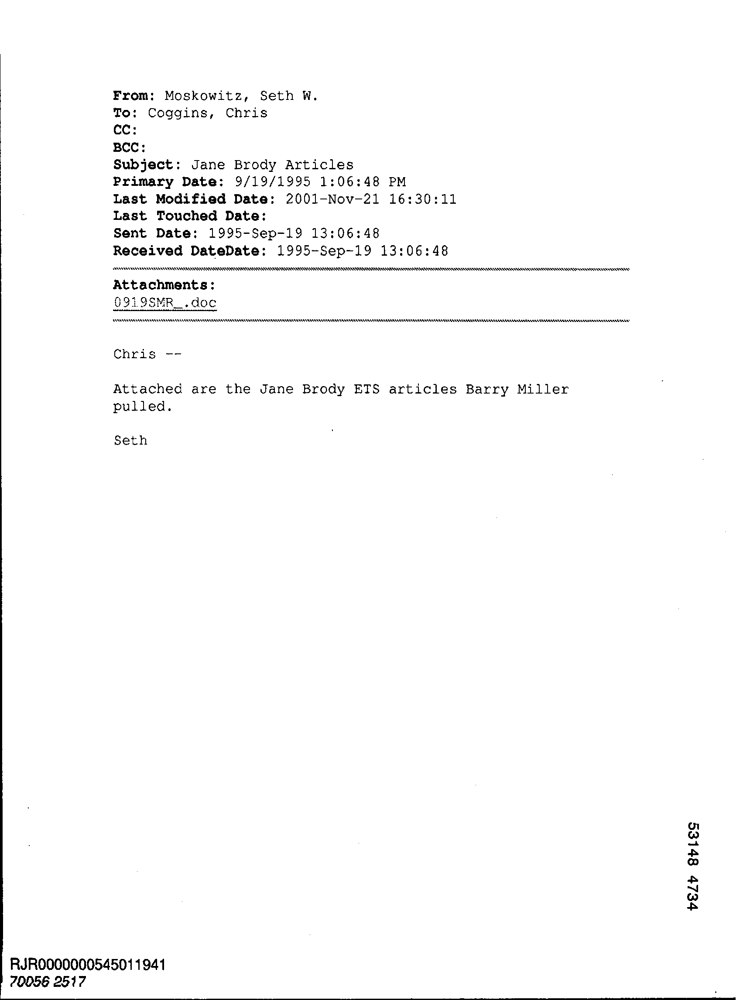

In [14]:
image